In [1]:
# 2018-2022년 전국 아파트 실거래 정보

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import openpyxl
import numpy as np
import re
from sklearn.preprocessing import StandardScaler, normalize, RobustScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as hc
from sklearn.cluster import AgglomerativeClustering
from haversine import haversine, Unit

In [3]:
df1 = pd.read_csv('/home/subin/다운로드/여피/0308 업무-20230310T030110Z-001/0308 업무/complex_20230308 (사본).csv', header=None)
df1.columns = ['old_addr_idx', 'complex_name', 'property_type','시도', '시군구',
               '읍면동','리','road_name','road_code','admin_dong_code','postal_code','jibun_main','jibun_sub','updated']
df1.drop(['road_name','road_code','admin_dong_code','postal_code','jibun_main','jibun_sub', 'updated'], axis=1, inplace=True)

df1['시군구'] = df1['시군구'].str.split().str[0]
df1 = df1[df1['property_type']!='officetel']
df1.drop(['property_type'], axis=1, inplace=True)

In [4]:
df2 = pd.read_csv('/home/subin/다운로드/여피/0308 업무-20230310T030110Z-001/0308 업무/property_20230308.csv', header=None)
df2.columns = ['pk','old_addr_idx','dong','ho','official_price','net_leasable_area','updated']

In [5]:
app_apt = df2.merge(df1, on='old_addr_idx')
pd.options.display.max_columns = None
app_apt['평수'] = app_apt['net_leasable_area'] / 3.3
app_apt.drop(['net_leasable_area'], axis=1, inplace=True)
app_apt.replace('\\N', np.nan, inplace=True)
app_apt['시군구'] = app_apt['시군구'].fillna('세종특별자치시')

In [6]:
areaCode = pd.read_excel('/home/subin/다운로드/행정_법정동 중심좌표_동별.xlsx')
areaCode = areaCode[areaCode['코드종류']=='B']
areaCode.drop(['코드', '코드종류'], axis=1, inplace=True)
areaCode['시군구'] = areaCode['시군구'].str.split().str[0]
#areaCode=areaCode.groupby(['시도', '시군구', '읍면동']).mean().reset_index()

In [7]:
areaCode

,시도,시군구,읍면동,리,위도,경도
3546,서울특별시,종로구,청운동,NaN,37.587111,126.969069
3547,서울특별시,종로구,신교동,NaN,37.583911,126.968354
3548,서울특별시,종로구,궁정동,NaN,37.584381,126.971489
3549,서울특별시,종로구,효자동,NaN,37.582416,126.971670
3550,서울특별시,종로구,창성동,NaN,37.580363,126.972065
...,...,...,...,...,...,...
22214,제주특별자치도,서귀포시,표선면,하천리,33.348068,126.832421
22215,제주특별자치도,서귀포시,표선면,성읍리,33.393144,126.794822
22216,제주특별자치도,서귀포시,표선면,가시리,33.354784,126.771072
22217,제주특별자치도,서귀포시,표선면,세화리,33.321147,126.798867


In [8]:
retail_seoul = pd.read_csv('/home/subin/다운로드/소상공인시장진흥공단_상가(상권)정보_서울_202212.csv')
retail_icn = pd.read_csv('/home/subin/다운로드/소상공인시장진흥공단_상가(상권)정보_인천_202212.csv')
retail_gghi = pd.read_csv('/home/subin/다운로드/소상공인시장진흥공단_상가(상권)정보_경기_202212.csv')

In [9]:
retail_seoul

,상가업소번호,상호명,지점명,상권업종대분류코드,상권업종대분류명,상권업종중분류코드,상권업종중분류명,상권업종소분류코드,상권업종소분류명,표준산업분류코드,표준산업분류명,시도코드,시도명,시군구코드,시군구명,행정동코드,행정동명,법정동코드,법정동명,지번코드,대지구분코드,대지구분명,지번본번지,지번부번지,지번주소,도로명코드,도로명,건물본번지,건물부번지,건물관리번호,건물명,도로명주소,구우편번호,신우편번호,동정보,층정보,호정보,경도,위도
0,23324279,제중건강원,NaN,D,소매,D10,건강/미용식품,D10A07,건강원,G47216,건강보조식품 소매업,11,서울특별시,11560,영등포구,1156053500,영등포동,1156010600,영등포동5가,1156010600100410001,1,대지,41,1.0,서울특별시 영등포구 영등포동5가 41-1,115604154799,서울특별시 영등포구 영중로14길,11,17.0,1156010600100410002034626,NaN,서울특별시 영등포구 영중로14길 11-17,150035,7250.0,NaN,1,NaN,126.907168,37.520613
1,24525909,민속악기사,NaN,D,소매,D04,취미/오락관련소매,D04A09,악기판매,G47593,악기 소매업,11,서울특별시,11200,성동구,1120079000,용답동,1120012200,용답동,1120012200101420011,1,대지,142,11.0,서울특별시 성동구 용답동 142-11,112004109480,서울특별시 성동구 용답5길,2,NaN,1120012200101420011000227,NaN,서울특별시 성동구 용답5길 2,133849,4803.0,NaN,NaN,NaN,127.049018,37.566857
2,24715368,태평양진주,NaN,D,소매,D26,시계/귀금속소매,D26A01,시계/귀금속,G47830,시계 및 귀금속 소매업,11,서울특별시,11110,종로구,1111061500,종로1.2.3.4가동,1111015200,봉익동,1111015200100430001,1,대지,43,1.0,서울특별시 종로구 봉익동 43-1,111104100163,서울특별시 종로구 서순라길,17,10.0,1111015200100440000000001,금사랑투빌딩,서울특별시 종로구 서순라길 17-10,110390,3138.0,NaN,NaN,NaN,126.993530,37.571848
3,15554136,김선희꼼꼼국어교습소,NaN,R,학문/교육,R01,학원-보습교습입시,R01A01,학원-입시,P85501,일반 교과 학원,11,서울특별시,11710,송파구,1171056100,방이1동,1171011100,방이동,1171011100101970003,1,대지,197,3.0,서울특별시 송파구 방이동 197-3,117104169448,서울특별시 송파구 위례성대로12길,31,NaN,1171011100101970003017195,NaN,서울특별시 송파구 위례성대로12길 31,138834,5640.0,NaN,2,NaN,127.121520,37.510967
4,17174175,비지트,NaN,Q,음식,Q01,한식,Q01A01,한식/백반/한정식,I56111,한식 음식점업,11,서울특별시,11650,서초구,1165062100,방배4동,1165010100,방배동,1165010100108540018,1,대지,854,18.0,서울특별시 서초구 방배동 854-18,116504163117,서울특별시 서초구 동광로18길,82,NaN,1165010100108540018009586,상랑의빌딩,서울특별시 서초구 동광로18길 82,137837,6572.0,NaN,1,NaN,126.991394,37.488375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377719,19079387,향나무참숯장어나라,NaN,Q,음식,Q01,한식,Q01A01,한식/백반/한정식,I56111,한식 음식점업,11,서울특별시,11380,은평구,1138057000,대조동,1138010600,대조동,1138010600100260008,1,대지,26,8.0,서울특별시 은평구 대조동 26-8,113803100020,서울특별시 은평구 진흥로,153,4.0,1138010600100260008026739,NaN,서울특별시 은평구 진흥로 153-4,122837,3396.0,NaN,1,NaN,126.926643,37.609327
377720,19079580,에이치에스컨설팅,NaN,L,부동산,L01,부동산중개,L01A01,부동산중개,L68221,부동산 자문 및 중개업,11,서울특별시,11320,도봉구,1132069000,방학1동,1132010600,방학동,1132010600106960040,1,대지,696,40.0,서울특별시 도봉구 방학동 696-40,113204127226,서울특별시 도봉구 방학로6길,38,NaN,1132010600106960040003438,NaN,서울특별시 도봉구 방학로6길 38,132852,1342.0,NaN,3,NaN,127.036563,37.664572
377721,19079781,크린에이드,가양역점,F,생활서비스,F02,세탁/가사서비스,F02A01,세탁소/빨래방,S96912,가정용 세탁업,11,서울특별시,11500,강서구,1150060400,가양2동,1150010400,가양동,1150010400100140003,1,대지,14,3.0,서울특별시 강서구 가양동 14-3,115003115008,서울특별시 강서구 양천로,489,NaN,1150010400100140003009639,가양우성아파트,서울특별시 강서구 양천로 489,157750,7526.0,상가,1,NaN,126.854188,37.562234
377722,19080385,멍,NaN,D,소매,D09,애견/애완/동물,D09A02,애완동물 미용실,S96995,애완동물 장묘 및 보호 서비스업,11,서울특별시,11320,도봉구,1132051200,창2동,1132010700,창동,1132010700105810012,1,대지,581,12.0,서울특별시 도봉구 창동 581-12,113204127042,서울특별시 도봉구 덕릉로59길,15,NaN,1132010700105810012017146,NaN,서울특별시 도봉구 덕릉로59길 15,132918,1470.0,NaN,NaN,NaN,127.038608,37.640459


In [10]:
korea = app_apt.merge(areaCode, on=['시도', '시군구', '읍면동', '리'], how='left')

In [11]:
fill = korea[korea['위도'].isnull()==True]
sidoList = fill['시도'].unique().tolist()

In [12]:
k=0
while k<3:
    code = areaCode[areaCode['시도']==sidoList[k]].groupby(['시도','시군구']).mean().reset_index()
    code['읍면동'] = np.nan
    korea = code.set_index(['시도', '시군구','읍면동']).combine_first(korea.set_index(['시도', '시군구', '읍면동'])).reset_index()
    k=k+1

/tmp/ipykernel_4453/3977428137.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  code = areaCode[areaCode['시도']==sidoList[k]].groupby(['시도','시군구']).mean().reset_index()
/tmp/ipykernel_4453/3977428137.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  code = areaCode[areaCode['시도']==sidoList[k]].groupby(['시도','시군구']).mean().reset_index()
/tmp/ipykernel_4453/3977428137.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function

In [13]:
k=3

mask = (korea['읍면동']=='퇴계원읍')
korea.loc[mask, '읍면동'] = '퇴계원면'
#korea.loc[mask, '위도'] = areaCode.iloc[1086,4]
#korea.loc[mask, '경도'] = areaCode.iloc[1086,5]

mask = (korea['읍면동']=='남사읍') & (korea['시군구']=='용인시')
korea.loc[mask, '읍면동'] = '남사면'

mask = (korea['읍면동']=='세종대왕면')
korea.loc[mask, '읍면동'] = '능서면'

mask = (korea['읍면동']=='배곧동')
korea.loc[mask, '위도'] = (areaCode.iloc[1086,4] + areaCode.iloc[2474,4])/2
korea.loc[mask, '경도'] = (areaCode.iloc[1086,5] + areaCode.iloc[2474,5])/2

mask = (korea['읍면동']=='고덕동')
korea.loc[mask, '위도'] = (areaCode.iloc[2231,4] + areaCode.iloc[2198,4])/2
korea.loc[mask, '경도'] = (areaCode.iloc[2231,5] + areaCode.iloc[2198,5])/2

code = areaCode[areaCode['시도']==sidoList[k]]
#areaCode[areaCode['시도']==sidoList[k]].groupby(['시도','시군구', '읍면동']).mean().reset_index()
mean_by_dong = code.groupby(['시도', '시군구', '읍면동']).mean().reset_index()
code = pd.concat([code, mean_by_dong], ignore_index=True)
code = code.sort_values(['시도', '시군구', '읍면동'])

mean_by_sigungu = code.groupby(['시도', '시군구']).mean().reset_index()
code = pd.concat([code, mean_by_sigungu], ignore_index=True)
code = code.sort_values(['시도', '시군구'])

korea = code.set_index(['시도', '시군구', '읍면동', '리']).combine_first(korea.set_index(['시도', '시군구', '읍면동', '리'])).reset_index()
korea = korea.dropna(subset='official_price')

/tmp/ipykernel_4453/1611477303.py:24: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_by_dong = code.groupby(['시도', '시군구', '읍면동']).mean().reset_index()
/tmp/ipykernel_4453/1611477303.py:28: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_by_sigungu = code.groupby(['시도', '시군구']).mean().reset_index()


In [14]:
k=4
mask = (korea['시도'] == sidoList[k]) & (korea['읍면동'] == '국토정중앙면') & (korea['리'] == '용하리')
korea.loc[mask, '위도'] = areaCode.iloc[4939, 4]
korea.loc[mask, '경도'] = areaCode.iloc[4939, 5]

code = areaCode[areaCode['시도']==sidoList[k]]

mean_by_sigungu = code.groupby(['시도', '시군구']).mean().reset_index()
code = pd.concat([code, mean_by_sigungu], ignore_index=True)
code = code.sort_values(['시도', '시군구'])

korea = code.set_index(['시도', '시군구', '읍면동', '리']).combine_first(korea.set_index(['시도', '시군구', '읍면동', '리'])).reset_index()
korea = korea.dropna(subset='official_price')

/tmp/ipykernel_4453/3168198780.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_by_sigungu = code.groupby(['시도', '시군구']).mean().reset_index()


In [15]:
k=5
mask = (korea['읍면동']=='덕산읍') & (korea['시군구']=='진천군')
korea.loc[mask, '읍면동'] = '덕산면'

code = areaCode[areaCode['시도']==sidoList[k]]

mean_by_sigungu = code.groupby(['시도', '시군구']).mean().reset_index()
code = pd.concat([code, mean_by_sigungu], ignore_index=True)
code = code.sort_values(['시도', '시군구'])

korea = code.set_index(['시도', '시군구', '읍면동', '리']).combine_first(korea.set_index(['시도', '시군구', '읍면동', '리'])).reset_index()
korea = korea.dropna(subset='official_price')

/tmp/ipykernel_4453/16090625.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_by_sigungu = code.groupby(['시도', '시군구']).mean().reset_index()


In [16]:
k=6
while k<8:
    code = areaCode[areaCode['시도']==sidoList[k]].groupby(['시도','시군구']).mean().reset_index()
    code['읍면동'] = np.nan
    korea = code.set_index(['시도', '시군구','읍면동']).combine_first(korea.set_index(['시도', '시군구', '읍면동'])).reset_index()
    k=k+1
korea = korea.dropna(subset='official_price')

/tmp/ipykernel_4453/2466147923.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  code = areaCode[areaCode['시도']==sidoList[k]].groupby(['시도','시군구']).mean().reset_index()
/tmp/ipykernel_4453/2466147923.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  code = areaCode[areaCode['시도']==sidoList[k]].groupby(['시도','시군구']).mean().reset_index()


In [17]:
k=8
code = areaCode[areaCode['시도']==sidoList[k]].groupby(['시도','시군구', '읍면동']).mean().reset_index()
code['리'] = np.nan
korea = code.set_index(['시도', '시군구', '읍면동','리']).combine_first(korea.set_index(['시도', '시군구', '읍면동', '리'])).reset_index()
korea = korea.dropna(subset='official_price')

mask = (korea['읍면동']=='집현동')
korea.loc[mask, '위도'] = 36.49079428910878
korea.loc[mask, '경도'] = 127.32149590280727

mask = (korea['읍면동']=='해밀동')
korea.loc[mask, '위도'] = 36.52793215288715
korea.loc[mask, '경도'] = 127.26619363637192

/tmp/ipykernel_4453/3793152101.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  code = areaCode[areaCode['시도']==sidoList[k]].groupby(['시도','시군구', '읍면동']).mean().reset_index()


In [18]:
k=9
mask = (korea['읍면동']=='여의동2가') & (korea['시군구']=='전주시')
korea.loc[mask, '읍면동'] = '동산동'

code = areaCode[areaCode['시도']==sidoList[k]]

mean_by_dong = code.groupby(['시도', '시군구', '읍면동']).mean().reset_index()
code = pd.concat([code, mean_by_dong], ignore_index=True)
code = code.sort_values(['시도', '시군구', '읍면동'])

mean_by_sigungu = code.groupby(['시도', '시군구']).mean().reset_index()
code = pd.concat([code, mean_by_sigungu], ignore_index=True)
code = code.sort_values(['시도', '시군구'])

korea = code.set_index(['시도', '시군구', '읍면동', '리']).combine_first(korea.set_index(['시도', '시군구', '읍면동', '리'])).reset_index()
korea = korea.dropna(subset='official_price')

/tmp/ipykernel_4453/694591620.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_by_dong = code.groupby(['시도', '시군구', '읍면동']).mean().reset_index()
/tmp/ipykernel_4453/694591620.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_by_sigungu = code.groupby(['시도', '시군구']).mean().reset_index()


In [19]:
k=11
mask = (korea['시도'] == sidoList[k]) & (korea['읍면동'] == '일로읍') & (korea['리'] == '오룡리')
korea.loc[mask, '위도'] = (areaCode.iloc[12471, 4] + areaCode.iloc[12472, 4])/2
korea.loc[mask, '경도'] = (areaCode.iloc[12471, 5] + areaCode.iloc[12472, 5])/2

mask = (korea['시도'] == '전라남도') & (korea['시군구'] == '목포시') & (korea['읍면동'].isnull()) & (korea['리'].isnull())
mean_E = korea.groupby(['시도', '시군구']).mean().reset_index()
mean_F = mean_E[mean_E['시군구']=='목포시']
korea.loc[mask, '위도'] = mean_F.iloc[0,4]
korea.loc[mask, '경도'] = mean_F.iloc[0,3]

mask = (korea['시도'] == sidoList[k]) & (korea['읍면동'] == '담양읍') & (korea['리'] == '담빛리')
korea.loc[mask, '위도'] = (areaCode.iloc[11261, 4] + areaCode.iloc[11262, 4])/2
korea.loc[mask, '경도'] = (areaCode.iloc[11261, 5] + areaCode.iloc[11262, 5])/2

code = areaCode[areaCode['시도']==sidoList[k]].groupby(['시도','시군구']).mean().reset_index()
code['읍면동'] = np.nan
code['리'] = np.nan
korea = code.set_index(['시도', '시군구','읍면동', '리']).combine_first(korea.set_index(['시도', '시군구', '읍면동', '리'])).reset_index()
korea = korea.dropna(subset='official_price')

/tmp/ipykernel_4453/617489863.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_E = korea.groupby(['시도', '시군구']).mean().reset_index()
/tmp/ipykernel_4453/617489863.py:16: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  code = areaCode[areaCode['시도']==sidoList[k]].groupby(['시도','시군구']).mean().reset_index()


In [20]:
k=13

mask = (korea['읍면동']=='산동읍')
korea.loc[mask, '읍면동'] = '산동면'

mask = (korea['읍면동']=='압량읍')
korea.loc[mask, '읍면동'] = '압량면'

mask = (korea['읍면동']=='문무대왕면')
korea.loc[mask, '읍면동'] = '양북면'

code = areaCode[areaCode['시도']==sidoList[k]]

mean_by_sigungu = code.groupby(['시도', '시군구']).mean().reset_index()
code = pd.concat([code, mean_by_sigungu], ignore_index=True)
code = code.sort_values(['시도', '시군구'])

korea = code.set_index(['시도', '시군구', '읍면동', '리']).combine_first(korea.set_index(['시도', '시군구', '읍면동', '리'])).reset_index()
korea = korea.dropna(subset='official_price')

/tmp/ipykernel_4453/317320241.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_by_sigungu = code.groupby(['시도', '시군구']).mean().reset_index()


In [21]:
k=15

mask = (korea['읍면동']=='삼남읍')
korea.loc[mask, '읍면동'] = '삼남면'
code = areaCode[areaCode['시도']==sidoList[k]]

mean_by_sigungu = code.groupby(['시도', '시군구']).mean().reset_index()
code = pd.concat([code, mean_by_sigungu], ignore_index=True)
code = code.sort_values(['시도', '시군구'])

korea = code.set_index(['시도', '시군구', '읍면동', '리']).combine_first(korea.set_index(['시도', '시군구', '읍면동', '리'])).reset_index()
korea = korea.dropna(subset='official_price')

/tmp/ipykernel_4453/1220808506.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_by_sigungu = code.groupby(['시도', '시군구']).mean().reset_index()


In [22]:
i=5

while i<9:
    k=i*2
    code = areaCode[areaCode['시도']==sidoList[k]].groupby(['시도','시군구']).mean().reset_index()
    code['읍면동'] = np.nan
    korea = code.set_index(['시도', '시군구', '읍면동']).combine_first(korea.set_index(['시도', '시군구', '읍면동'])).reset_index()
    i=i+1

/tmp/ipykernel_4453/18131018.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  code = areaCode[areaCode['시도']==sidoList[k]].groupby(['시도','시군구']).mean().reset_index()
/tmp/ipykernel_4453/18131018.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  code = areaCode[areaCode['시도']==sidoList[k]].groupby(['시도','시군구']).mean().reset_index()
/tmp/ipykernel_4453/18131018.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  co

In [23]:
main = korea[(korea['시도']=='서울특별시')|(korea['시도']=='경기도')|(korea['시도']=='인천광역시')]
main

,시도,시군구,읍면동,complex_name,dong,ho,official_price,old_addr_idx,pk,updated,경도,리,위도,평수
391136,경기도,가평군,가평읍,삼성세르빌,삼성 세르빌 1,101,53400000.0,4182025027_00240_00001_apartment,20072777_0001_0001,2021-01-01,127.489038,경반리,37.833291,23.309091
391137,경기도,가평군,가평읍,삼성세르빌,삼성 세르빌 1,102,53400000.0,4182025027_00240_00001_apartment,20072777_0001_0002,2021-01-01,127.489038,경반리,37.833291,23.309091
391138,경기도,가평군,가평읍,삼성세르빌,삼성 세르빌 1,201,56400000.0,4182025027_00240_00001_apartment,20072777_0001_0003,2021-01-01,127.489038,경반리,37.833291,23.309091
391139,경기도,가평군,가평읍,삼성세르빌,삼성 세르빌 1,202,56400000.0,4182025027_00240_00001_apartment,20072777_0001_0004,2021-01-01,127.489038,경반리,37.833291,23.309091
391140,경기도,가평군,가평읍,삼성세르빌,삼성 세르빌 1,301,56400000.0,4182025027_00240_00001_apartment,20072777_0001_0005,2021-01-01,127.489038,경반리,37.833291,23.309091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15924998,인천광역시,중구,NaN,더원빌리지 101동,주건축물제1,302,134000000.0,2811014800_00453_00066_apartment,20358128_0001_0006,2021-01-01,126.600268,NaN,37.470681,15.739394
15924999,인천광역시,중구,NaN,더원빌리지 101동,주건축물제1,401,134000000.0,2811014800_00453_00066_apartment,20358128_0001_0007,2021-01-01,126.600268,NaN,37.470681,15.739394
15925000,인천광역시,중구,NaN,더원빌리지 101동,주건축물제1,402,134000000.0,2811014800_00453_00066_apartment,20358128_0001_0008,2021-01-01,126.600268,NaN,37.470681,15.739394
15925001,인천광역시,중구,NaN,더원빌리지 101동,주건축물제1,B01,125000000.0,2811014800_00453_00066_apartment,20358128_0001_0009,2021-01-01,126.600268,NaN,37.470681,15.739394


In [24]:
main_name = main[['old_addr_idx', '위도', '경도']]
main_name = main_name.drop_duplicates()
main_name['위도+경도'] = main_name['위도'].astype(str) + main_name['경도'].astype(str)

In [25]:
mainArea = main[['위도', '경도']]
mainArea = mainArea.drop_duplicates()
mainArea['위도+경도'] = mainArea['위도'].astype(str) + mainArea['경도'].astype(str)

In [26]:
mainArea

,위도,경도,위도+경도
391136,37.833291,127.489038,37.833291127.489038
391155,37.757186,127.532969,37.757186127.532969
391178,37.810731,127.519890,37.810731127.51989
391606,37.823477,127.511021,37.823477127.511021
392452,37.738609,127.503730,37.738609127.50373
...,...,...,...
15906781,37.503478,126.553969,37.503478126.553969
15921699,37.473492,126.620486,37.473492126.620486
15921703,37.472132,126.622960,37.472132126.62296
15921725,37.451976,126.606149,37.451976126.606149


In [27]:
import math

minLatList = []
maxLatList = []
minLonList = []
maxLonList = []

def calculate_bounding_box(latitude, longitude, distance_km):
    # Earth's radius in km
    radius_km = 6371

    # Convert distance from km to radians
    distance_radians = distance_km / radius_km

    # Convert latitude and longitude to radians
    lat_radians = math.radians(latitude)
    lon_radians = math.radians(longitude)

    # Calculate the minimum and maximum latitude and longitude
    min_lat = math.degrees(lat_radians - distance_radians)
    max_lat = math.degrees(lat_radians + distance_radians)
    min_lon = math.degrees(lon_radians - distance_radians / math.cos(lat_radians))
    max_lon = math.degrees(lon_radians + distance_radians / math.cos(lat_radians))

    return (min_lat, max_lat, min_lon, max_lon)

k=0
while k<1700:
    lat = mainArea.iloc[k,0]
    lon = mainArea.iloc[k,1]
    distance_km = 5
    
    min_lat, max_lat, min_lon, max_lon = calculate_bounding_box(lat, lon, distance_km)

    minLatList = minLatList+[min_lat]
    maxLatList = maxLatList+[max_lat]
    minLonList = minLonList+[min_lon]
    maxLonList = maxLonList+[max_lon]

    k=k+1


In [28]:
mainArea['minLat']=minLatList
mainArea['maxLat']=maxLatList
mainArea['minLon']=minLonList
mainArea['maxLon']=maxLonList

In [29]:
mainArea

,위도,경도,위도+경도,minLat,maxLat,minLon,maxLon
391136,37.833291,127.489038,37.833291127.489038,37.788325,37.878257,127.432104,127.545972
391155,37.757186,127.532969,37.757186127.532969,37.712220,37.802152,127.476094,127.589844
391178,37.810731,127.519890,37.810731127.51989,37.765765,37.855697,127.462974,127.576806
391606,37.823477,127.511021,37.823477127.511021,37.778511,37.868443,127.454095,127.567947
392452,37.738609,127.503730,37.738609127.50373,37.693643,37.783575,127.446869,127.560591
...,...,...,...,...,...,...,...
15906781,37.503478,126.553969,37.503478126.553969,37.458512,37.548444,126.497288,126.610650
15921699,37.473492,126.620486,37.473492126.620486,37.428526,37.518458,126.563828,126.677144
15921703,37.472132,126.622960,37.472132126.62296,37.427166,37.517098,126.566303,126.679617
15921725,37.451976,126.606149,37.451976126.606149,37.407010,37.496942,126.549507,126.662791


In [30]:
school = pd.read_excel('/home/subin/다운로드/전국초중등학교위치표준데이터-20230404.xls')
school.rename(columns=school.iloc[0], inplace=True)
school = school.drop(0)

school['시도']=school['시도교육청명'].str.split('교육청').str[0]
school.drop(['시도교육청명', '제공기관명', '생성일자', '변경일자', '교육지원청명', '데이터기준일자','소재지지번주소', '소재지도로명주소', '설립일자',
             '학교ID', '제공기관코드', '시도교육청코드', '교육지원청코드', '운영상태'], axis=1, inplace=True)
school['학교급구분'] = school['학교급구분'].str.split('학교').str[0]

school['위도'] = school['위도'].astype(float).round(6)
school['경도'] = school['경도'].astype(float).round(6)

#school

In [31]:
school_main = school[(school['시도']=='서울특별시')|(school['시도']=='경기도')|(school['시도']=='인천광역시')]
school_main

,학교명,학교급구분,설립형태,본교분교구분,위도,경도,시도
7,하안중학교,중,공립,본교,37.467386,126.880772,경기도
8,현산중학교,중,공립,본교,37.691246,126.774003,경기도
9,은광여자고등학교,고등,사립,본교,37.488379,127.035232,서울특별시
12,숭덕여자고등학교,고등,사립,본교,37.464282,126.733917,인천광역시
13,산마을고등학교,고등,사립,본교,37.686363,126.425565,인천광역시
...,...,...,...,...,...,...,...
11975,서울문영여자고등학교,고등,사립,본교,37.472905,126.950918,서울특별시
11976,서울갈산초등학교,초등,공립,본교,37.512372,126.870230,서울특별시
11977,서울태랑초등학교,초등,공립,본교,37.628783,127.088992,서울특별시
11978,서울한천초등학교,초등,공립,본교,37.620709,127.069244,서울특별시


In [32]:
school_ele = school_main[school_main['학교급구분']=='초등']
school_mid = school_main[school_main['학교급구분']=='중']
school_high = school_main[school_main['학교급구분']=='고등']

In [33]:
school_mainArea= school_main.drop(['학교급구분', '설립형태', '본교분교구분', '시도'], axis=1)
school_eleArea = school_ele.drop(['학교급구분', '설립형태', '본교분교구분', '시도'], axis=1)
school_midArea = school_mid.drop(['학교급구분', '설립형태', '본교분교구분', '시도'], axis=1)
school_highArea = school_high.drop(['학교급구분', '설립형태', '본교분교구분', '시도'], axis=1)
#school_seoul_all

In [34]:
subway = pd.read_csv('/home/subin/다운로드/서울시 역사마스터 정보.csv',encoding='cp949')
subway_name = subway.drop(['역사_ID', '호선'], axis=1)
subway_name.drop_duplicates(inplace=True)
subway_name['환승역'] = 0  # set all values in the '환승역' column to 0 first
duplicates = subway_name['역사명'].duplicated()  # identify duplicated values in the '역사명' column
subway_name.loc[duplicates, '환승역'] = 1  # set the '환승역' column to 1 only for duplicated rows
subway_name = subway_name[subway_name['환승역'] != 1]
subway_name = subway_name.rename(columns={'위도': '경도', '경도': '위도'})

In [35]:
subway_name

,역사명,경도,위도,환승역
0,미사,127.193877,37.560927,0
1,강일,127.175930,37.557490,0
2,김포공항,126.801868,37.562360,0
3,고촌,126.770345,37.601243,0
4,풍무,126.732387,37.612488,0
...,...,...,...,...
753,을지로입구,126.982618,37.566014,0
754,시청,126.975411,37.563588,0
757,제기동,127.034893,37.578103,0
760,종로5가,127.001849,37.570926,0


In [36]:
from scipy.spatial.distance import cdist
housing_coords = mainArea[['위도', '경도']].values
subway_coords = subway_name[['위도', '경도']].values
distances_matrix = cdist(housing_coords, subway_coords, metric=haversine)
distances_df = pd.DataFrame(distances_matrix, columns=subway_name['역사명'], index=mainArea['위도+경도'])
distances_df = distances_df.reset_index().melt(id_vars='위도+경도', var_name='subway_id', value_name='distance')

In [37]:
distances_df['subway_id'] = distances_df['subway_id'].replace('총신대입구', '이수')

In [38]:
mainArea

,위도,경도,위도+경도,minLat,maxLat,minLon,maxLon
391136,37.833291,127.489038,37.833291127.489038,37.788325,37.878257,127.432104,127.545972
391155,37.757186,127.532969,37.757186127.532969,37.712220,37.802152,127.476094,127.589844
391178,37.810731,127.519890,37.810731127.51989,37.765765,37.855697,127.462974,127.576806
391606,37.823477,127.511021,37.823477127.511021,37.778511,37.868443,127.454095,127.567947
392452,37.738609,127.503730,37.738609127.50373,37.693643,37.783575,127.446869,127.560591
...,...,...,...,...,...,...,...
15906781,37.503478,126.553969,37.503478126.553969,37.458512,37.548444,126.497288,126.610650
15921699,37.473492,126.620486,37.473492126.620486,37.428526,37.518458,126.563828,126.677144
15921703,37.472132,126.622960,37.472132126.62296,37.427166,37.517098,126.566303,126.679617
15921725,37.451976,126.606149,37.451976126.606149,37.407010,37.496942,126.549507,126.662791


In [39]:
dis_df_162km = distances_df[distances_df['distance']<162]
main_subway_162km = main_name.merge(dis_df_162km, on='위도+경도')
main_subway_162km.drop(['위도', '경도', '위도+경도'], axis=1, inplace=True)

In [40]:
main_subway_1km =main_subway_162km[main_subway_162km['distance']<=1]
main_subway = pd.merge(main_name, main_subway_1km, how='left', on='old_addr_idx')
value_counts = main_subway[main_subway['distance']<=1]['old_addr_idx'].value_counts()
main['1km내sub수'] = main['old_addr_idx'].map(value_counts)
main['1km내sub수'] = main['1km내sub수'].fillna(0)

/tmp/ipykernel_4453/3984357033.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main['1km내sub수'] = main['old_addr_idx'].map(value_counts)
/tmp/ipykernel_4453/3984357033.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main['1km내sub수'] = main['1km내sub수'].fillna(0)


In [41]:
closest_subway_dis =main_subway_162km.groupby('old_addr_idx').min().drop('subway_id', axis=1).reset_index()
main = main.merge(closest_subway_dis, how='left', on='old_addr_idx')
main = main.rename(columns={'distance': 'closest_sub'})

In [42]:
main['sub_0.5km'] = (main['closest_sub'] < 0.5).astype(int)

In [43]:
main

,시도,시군구,읍면동,complex_name,dong,ho,official_price,old_addr_idx,pk,updated,경도,리,위도,평수,1km내sub수,closest_sub,sub_0.5km
0,경기도,가평군,가평읍,삼성세르빌,삼성 세르빌 1,101,53400000.0,4182025027_00240_00001_apartment,20072777_0001_0001,2021-01-01,127.489038,경반리,37.833291,23.309091,0.0,2.825284,0
1,경기도,가평군,가평읍,삼성세르빌,삼성 세르빌 1,102,53400000.0,4182025027_00240_00001_apartment,20072777_0001_0002,2021-01-01,127.489038,경반리,37.833291,23.309091,0.0,2.825284,0
2,경기도,가평군,가평읍,삼성세르빌,삼성 세르빌 1,201,56400000.0,4182025027_00240_00001_apartment,20072777_0001_0003,2021-01-01,127.489038,경반리,37.833291,23.309091,0.0,2.825284,0
3,경기도,가평군,가평읍,삼성세르빌,삼성 세르빌 1,202,56400000.0,4182025027_00240_00001_apartment,20072777_0001_0004,2021-01-01,127.489038,경반리,37.833291,23.309091,0.0,2.825284,0
4,경기도,가평군,가평읍,삼성세르빌,삼성 세르빌 1,301,56400000.0,4182025027_00240_00001_apartment,20072777_0001_0005,2021-01-01,127.489038,경반리,37.833291,23.309091,0.0,2.825284,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10997792,인천광역시,중구,NaN,더원빌리지 101동,주건축물제1,302,134000000.0,2811014800_00453_00066_apartment,20358128_0001_0006,2021-01-01,126.600268,NaN,37.470681,15.739394,0.0,1.634313,0
10997793,인천광역시,중구,NaN,더원빌리지 101동,주건축물제1,401,134000000.0,2811014800_00453_00066_apartment,20358128_0001_0007,2021-01-01,126.600268,NaN,37.470681,15.739394,0.0,1.634313,0
10997794,인천광역시,중구,NaN,더원빌리지 101동,주건축물제1,402,134000000.0,2811014800_00453_00066_apartment,20358128_0001_0008,2021-01-01,126.600268,NaN,37.470681,15.739394,0.0,1.634313,0
10997795,인천광역시,중구,NaN,더원빌리지 101동,주건축물제1,B01,125000000.0,2811014800_00453_00066_apartment,20358128_0001_0009,2021-01-01,126.600268,NaN,37.470681,15.739394,0.0,1.634313,0


In [44]:
#import numpy as np
#from scipy.spatial.distance import cdist

# Filter the mainArea DataFrame to include only the rows where the latitude and longitude values are within the specified ranges
#filtered_mainArea = mainArea.loc[(mainArea['lat'] >= mainArea['minLat']) & (mainArea['lat'] <= mainArea['maxLat']) & (mainArea['lon'] >= mainArea['minLon']) & (mainArea['lon'] <= mainArea['maxLon'])]

# Extract the latitude and longitude values from the filtered DataFrame and the school_main DataFrame
#housing_coords = filtered_mainArea[['lat', 'lon']].values
#school_coords = school_main[['lat', 'lon']].values

# Compute the distances between the housing and school coordinates
#distances_matrix2 = cdist(housing_coords, school_coords, metric='haversine')


In [45]:
housing_coords = mainArea[['위도', '경도']].values
school_coords = school_main[['위도', '경도']].values
distances_matrix2 = cdist(housing_coords, school_coords, metric=haversine)
distances_df2 = pd.DataFrame(distances_matrix2, columns=school_main['학교명'], index=mainArea['위도+경도'])
distances_df2 = distances_df2.reset_index().melt(id_vars='위도+경도', var_name='school_id', value_name='distance')

In [46]:
dis_df2_25km = distances_df2[distances_df2['distance']<25]
dis_df2_25km['school_id'] = dis_df2_25km['school_id'].replace('인천과학예술영재학교', '인천과학예술영재고등학교')
dis_df2_25km['school_id'] = dis_df2_25km['school_id'].replace('동성고등공민학교', '동성공민고등학교')

/tmp/ipykernel_4453/3156379023.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dis_df2_25km['school_id'] = dis_df2_25km['school_id'].replace('인천과학예술영재학교', '인천과학예술영재고등학교')
/tmp/ipykernel_4453/3156379023.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dis_df2_25km['school_id'] = dis_df2_25km['school_id'].replace('동성고등공민학교', '동성공민고등학교')


In [47]:
main_name

,old_addr_idx,위도,경도,위도+경도
391136,4182025027_00240_00001_apartment,37.833291,127.489038,37.833291127.489038
391155,4182025034_00613_00008_apartment,37.757186,127.532969,37.757186127.532969
391174,4182025034_00613_00016_apartment,37.757186,127.532969,37.757186127.532969
391178,4182025023_00281_00000_apartment,37.810731,127.519890,37.810731127.51989
391316,4182025023_00285_00001_apartment,37.810731,127.519890,37.810731127.51989
...,...,...,...,...
15924954,2811014800_00453_00015_apartment,37.470681,126.600268,37.4706810576923126.6002675576923
15924963,2811014800_00453_00016_apartment,37.470681,126.600268,37.4706810576923126.6002675576923
15924973,2811014800_00453_00063_apartment,37.470681,126.600268,37.4706810576923126.6002675576923
15924983,2811014800_00453_00064_apartment,37.470681,126.600268,37.4706810576923126.6002675576923


In [48]:
dis_ele_25km = dis_df2_25km[dis_df2_25km['school_id'].str.contains('초등학교')]
dis_mid_25km = dis_df2_25km[dis_df2_25km['school_id'].str.contains('중학교')]
dis_high_25km = dis_df2_25km[dis_df2_25km['school_id'].str.contains('고등학교')]

In [49]:
dis_ele_25km

,위도+경도,school_id,distance
8529,37.693249126.720468,인천청람초등학교,18.416353
8530,37.605248126.844032,인천청람초등학교,19.012774
8533,37.687237126.699598,인천청람초등학교,17.195230
8534,37.640834126.80753,인천청람초등학교,18.255923
8537,37.637569126.815041,인천청람초등학교,18.561522
...,...,...,...
7388082,37.529584126.750621,서울신구초등학교,24.117334
7388084,37.542069126.742934,서울신구초등학교,24.870365
7388099,37.439081126.766117,서울신구초등학교,24.608944
7388100,37.454008126.754685,서울신구초등학교,24.981144


In [50]:
main_high_25km = main_name.merge(dis_high_25km.drop('school_id', axis=1), on='위도+경도')
closest_high_dis = main_high_25km.drop(['위도', '경도', '위도+경도'], axis=1).groupby('old_addr_idx').min().reset_index()

In [51]:
main = main.merge(closest_high_dis, how='left', on='old_addr_idx')
main = main.rename(columns={'distance': 'closest_high'})

In [52]:
main_mid_25km = main_name.merge(dis_mid_25km.drop('school_id', axis=1), on='위도+경도')
closest_mid_dis = main_mid_25km.drop(['위도', '경도', '위도+경도'], axis=1).groupby('old_addr_idx').min().reset_index()

In [53]:
main = main.merge(closest_mid_dis, how='left', on='old_addr_idx')
main = main.rename(columns={'distance': 'closest_mid'})

In [54]:
main_ele_25km = main_name.merge(dis_ele_25km.drop('school_id', axis=1), on='위도+경도')
closest_ele_dis = main_ele_25km.drop(['위도', '경도', '위도+경도'], axis=1).groupby('old_addr_idx').min().reset_index()

In [55]:
main = main.merge(closest_ele_dis, how='left', on='old_addr_idx')
main = main.rename(columns={'distance': 'closest_ele'})

In [56]:
closest_ele_dis

,old_addr_idx,distance
0,1111010100_00001_00000_apartment,0.133197
1,1111010100_00003_00000_apartment,0.133197
2,1111010100_00003_00150_apartment,0.133197
3,1111010100_00004_00001_apartment,0.133197
4,1111010100_00004_00003_apartment,0.133197
...,...,...
214753,4183041021_00220_00017_apartment,0.547599
214754,4183041021_00224_00016_apartment,0.547599
214755,4183041021_00285_00001_apartment,0.547599
214756,4183041021_00295_00016_apartment,0.547599


In [57]:
dis_school_3km = dis_df2_25km[dis_df2_25km['distance']<3]

In [58]:
main_name

,old_addr_idx,위도,경도,위도+경도
391136,4182025027_00240_00001_apartment,37.833291,127.489038,37.833291127.489038
391155,4182025034_00613_00008_apartment,37.757186,127.532969,37.757186127.532969
391174,4182025034_00613_00016_apartment,37.757186,127.532969,37.757186127.532969
391178,4182025023_00281_00000_apartment,37.810731,127.519890,37.810731127.51989
391316,4182025023_00285_00001_apartment,37.810731,127.519890,37.810731127.51989
...,...,...,...,...
15924954,2811014800_00453_00015_apartment,37.470681,126.600268,37.4706810576923126.6002675576923
15924963,2811014800_00453_00016_apartment,37.470681,126.600268,37.4706810576923126.6002675576923
15924973,2811014800_00453_00063_apartment,37.470681,126.600268,37.4706810576923126.6002675576923
15924983,2811014800_00453_00064_apartment,37.470681,126.600268,37.4706810576923126.6002675576923


In [59]:
main_school_3km = main_name.merge(dis_school_3km.drop('school_id', axis=1), on='위도+경도')

In [60]:
main_school_1km =main_school_3km[main_school_3km['distance']<=1]
main_school = pd.merge(main_name, main_school_1km, how='left', on='old_addr_idx')
value_counts2 = main_school[main_school['distance']<=1]['old_addr_idx'].value_counts()
main['school_1km'] = main['old_addr_idx'].map(value_counts2)
main['school_1km'] = main['school_1km'].fillna(0)

In [61]:
main

,시도,시군구,읍면동,complex_name,dong,ho,official_price,old_addr_idx,pk,updated,경도,리,위도,평수,1km내sub수,closest_sub,sub_0.5km,closest_high,closest_mid,closest_ele,school_1km
0,경기도,가평군,가평읍,삼성세르빌,삼성 세르빌 1,101,53400000.0,4182025027_00240_00001_apartment,20072777_0001_0001,2021-01-01,127.489038,경반리,37.833291,23.309091,0.0,2.825284,0,2.691795,1.951456,1.626459,0.0
1,경기도,가평군,가평읍,삼성세르빌,삼성 세르빌 1,102,53400000.0,4182025027_00240_00001_apartment,20072777_0001_0002,2021-01-01,127.489038,경반리,37.833291,23.309091,0.0,2.825284,0,2.691795,1.951456,1.626459,0.0
2,경기도,가평군,가평읍,삼성세르빌,삼성 세르빌 1,201,56400000.0,4182025027_00240_00001_apartment,20072777_0001_0003,2021-01-01,127.489038,경반리,37.833291,23.309091,0.0,2.825284,0,2.691795,1.951456,1.626459,0.0
3,경기도,가평군,가평읍,삼성세르빌,삼성 세르빌 1,202,56400000.0,4182025027_00240_00001_apartment,20072777_0001_0004,2021-01-01,127.489038,경반리,37.833291,23.309091,0.0,2.825284,0,2.691795,1.951456,1.626459,0.0
4,경기도,가평군,가평읍,삼성세르빌,삼성 세르빌 1,301,56400000.0,4182025027_00240_00001_apartment,20072777_0001_0005,2021-01-01,127.489038,경반리,37.833291,23.309091,0.0,2.825284,0,2.691795,1.951456,1.626459,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10997792,인천광역시,중구,NaN,더원빌리지 101동,주건축물제1,302,134000000.0,2811014800_00453_00066_apartment,20358128_0001_0006,2021-01-01,126.600268,NaN,37.470681,15.739394,0.0,1.634313,0,0.258733,2.164478,1.998017,1.0
10997793,인천광역시,중구,NaN,더원빌리지 101동,주건축물제1,401,134000000.0,2811014800_00453_00066_apartment,20358128_0001_0007,2021-01-01,126.600268,NaN,37.470681,15.739394,0.0,1.634313,0,0.258733,2.164478,1.998017,1.0
10997794,인천광역시,중구,NaN,더원빌리지 101동,주건축물제1,402,134000000.0,2811014800_00453_00066_apartment,20358128_0001_0008,2021-01-01,126.600268,NaN,37.470681,15.739394,0.0,1.634313,0,0.258733,2.164478,1.998017,1.0
10997795,인천광역시,중구,NaN,더원빌리지 101동,주건축물제1,B01,125000000.0,2811014800_00453_00066_apartment,20358128_0001_0009,2021-01-01,126.600268,NaN,37.470681,15.739394,0.0,1.634313,0,0.258733,2.164478,1.998017,1.0


In [62]:
main

,시도,시군구,읍면동,complex_name,dong,ho,official_price,old_addr_idx,pk,updated,경도,리,위도,평수,1km내sub수,closest_sub,sub_0.5km,closest_high,closest_mid,closest_ele,school_1km
0,경기도,가평군,가평읍,삼성세르빌,삼성 세르빌 1,101,53400000.0,4182025027_00240_00001_apartment,20072777_0001_0001,2021-01-01,127.489038,경반리,37.833291,23.309091,0.0,2.825284,0,2.691795,1.951456,1.626459,0.0
1,경기도,가평군,가평읍,삼성세르빌,삼성 세르빌 1,102,53400000.0,4182025027_00240_00001_apartment,20072777_0001_0002,2021-01-01,127.489038,경반리,37.833291,23.309091,0.0,2.825284,0,2.691795,1.951456,1.626459,0.0
2,경기도,가평군,가평읍,삼성세르빌,삼성 세르빌 1,201,56400000.0,4182025027_00240_00001_apartment,20072777_0001_0003,2021-01-01,127.489038,경반리,37.833291,23.309091,0.0,2.825284,0,2.691795,1.951456,1.626459,0.0
3,경기도,가평군,가평읍,삼성세르빌,삼성 세르빌 1,202,56400000.0,4182025027_00240_00001_apartment,20072777_0001_0004,2021-01-01,127.489038,경반리,37.833291,23.309091,0.0,2.825284,0,2.691795,1.951456,1.626459,0.0
4,경기도,가평군,가평읍,삼성세르빌,삼성 세르빌 1,301,56400000.0,4182025027_00240_00001_apartment,20072777_0001_0005,2021-01-01,127.489038,경반리,37.833291,23.309091,0.0,2.825284,0,2.691795,1.951456,1.626459,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10997792,인천광역시,중구,NaN,더원빌리지 101동,주건축물제1,302,134000000.0,2811014800_00453_00066_apartment,20358128_0001_0006,2021-01-01,126.600268,NaN,37.470681,15.739394,0.0,1.634313,0,0.258733,2.164478,1.998017,1.0
10997793,인천광역시,중구,NaN,더원빌리지 101동,주건축물제1,401,134000000.0,2811014800_00453_00066_apartment,20358128_0001_0007,2021-01-01,126.600268,NaN,37.470681,15.739394,0.0,1.634313,0,0.258733,2.164478,1.998017,1.0
10997794,인천광역시,중구,NaN,더원빌리지 101동,주건축물제1,402,134000000.0,2811014800_00453_00066_apartment,20358128_0001_0008,2021-01-01,126.600268,NaN,37.470681,15.739394,0.0,1.634313,0,0.258733,2.164478,1.998017,1.0
10997795,인천광역시,중구,NaN,더원빌리지 101동,주건축물제1,B01,125000000.0,2811014800_00453_00066_apartment,20358128_0001_0009,2021-01-01,126.600268,NaN,37.470681,15.739394,0.0,1.634313,0,0.258733,2.164478,1.998017,1.0


In [64]:
main_withPrice =main.drop(['old_addr_idx', 'complex_name', 'dong', 'ho', '시도', '시군구', '읍면동', 'pk', 'updated', '리'], axis=1)
main_withPrice

,official_price,경도,위도,평수,1km내sub수,closest_sub,sub_0.5km,closest_high,closest_mid,closest_ele,school_1km
0,53400000.0,127.489038,37.833291,23.309091,0.0,2.825284,0,2.691795,1.951456,1.626459,0.0
1,53400000.0,127.489038,37.833291,23.309091,0.0,2.825284,0,2.691795,1.951456,1.626459,0.0
2,56400000.0,127.489038,37.833291,23.309091,0.0,2.825284,0,2.691795,1.951456,1.626459,0.0
3,56400000.0,127.489038,37.833291,23.309091,0.0,2.825284,0,2.691795,1.951456,1.626459,0.0
4,56400000.0,127.489038,37.833291,23.309091,0.0,2.825284,0,2.691795,1.951456,1.626459,0.0
...,...,...,...,...,...,...,...,...,...,...,...
10997792,134000000.0,126.600268,37.470681,15.739394,0.0,1.634313,0,0.258733,2.164478,1.998017,1.0
10997793,134000000.0,126.600268,37.470681,15.739394,0.0,1.634313,0,0.258733,2.164478,1.998017,1.0
10997794,134000000.0,126.600268,37.470681,15.739394,0.0,1.634313,0,0.258733,2.164478,1.998017,1.0
10997795,125000000.0,126.600268,37.470681,15.739394,0.0,1.634313,0,0.258733,2.164478,1.998017,1.0


In [74]:
main_withPrice.drop('1km내sub수+', axis=1, inplace=True)

In [76]:

main_withPrice['school_1km+'] = main_withPrice['school_1km']+1
#main_withPrice['sub_1km+'] = main_withPrice['sub_1km']+1

In [ ]:
main_withPrice_skew = main_withPrice[['official_price', '경도', '위도', '평수', '지하철역수+', '학교수+', 'closest_sub', 'closest_school']]

In [68]:
from scipy import stats

-0.7457630673514675
0.9386327359862362
0.06925725129547808


/home/subin/다운로드/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)
/home/subin/다운로드/venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)


/home/subin/다운로드/venv/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/home/subin/다운로드/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


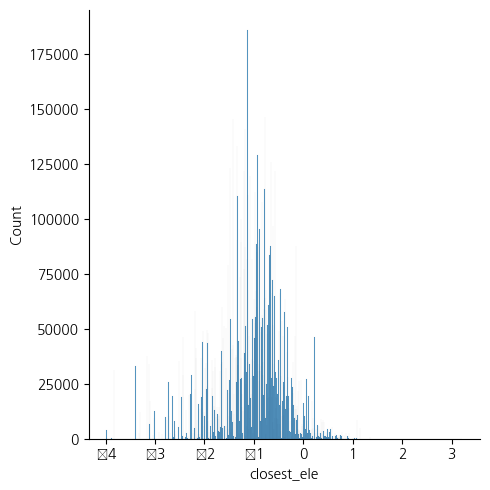

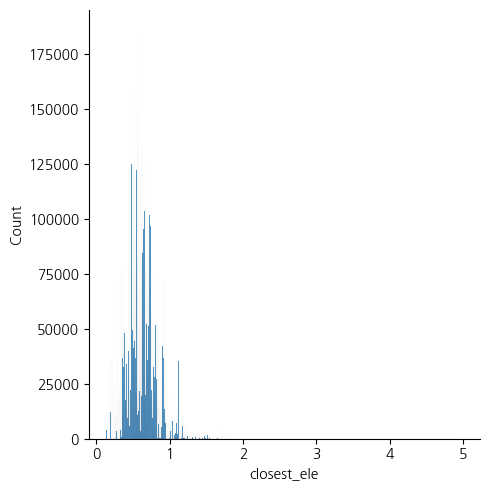

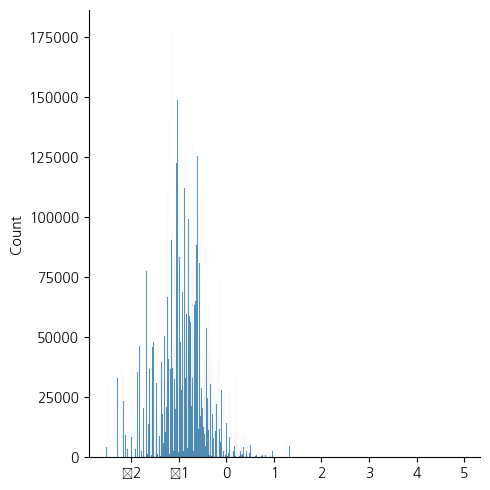

In [80]:
df_log = np.log(main_withPrice['closest_ele'])
print(df_log.skew())

df_root = np.sqrt(main_withPrice['closest_ele'])
print(df_root.skew())

df_boxcox = pd.Series(stats.boxcox(main_withPrice['closest_ele'])[0])
print(df_boxcox.skew())

sns.displot(df_log)
sns.displot(df_root)
sns.displot(df_boxcox)

In [ ]:
sns.displot(df_log)
sns.displot(df_root)
sns.displot(df_boxcox)

In [ ]:
main_withPrice_skew = main_withPrice[['official_price', '경도', '위도', '평수', '지하철역수+', '학교수+', 'closest_sub', 'sub_1km+', 'closest_school']]

In [83]:
from scipy.stats import boxcox
main_withPrice[['평수']] = main_withPrice[[ '평수']].apply(lambda x: boxcox(x)[0])
main_withPrice[['경도', '위도', 'school_1km+']] = np.sqrt(main_withPrice[['경도', '위도', 'school_1km+']])
main_withPrice[['official_price', 'closest_sub', 'closest_high', 'closest_ele', 'closest_mid']] = np.log(main_withPrice[['official_price', 'closest_sub', 'closest_high', 'closest_ele', 'closest_mid']])

/home/subin/다운로드/venv/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/home/subin/다운로드/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


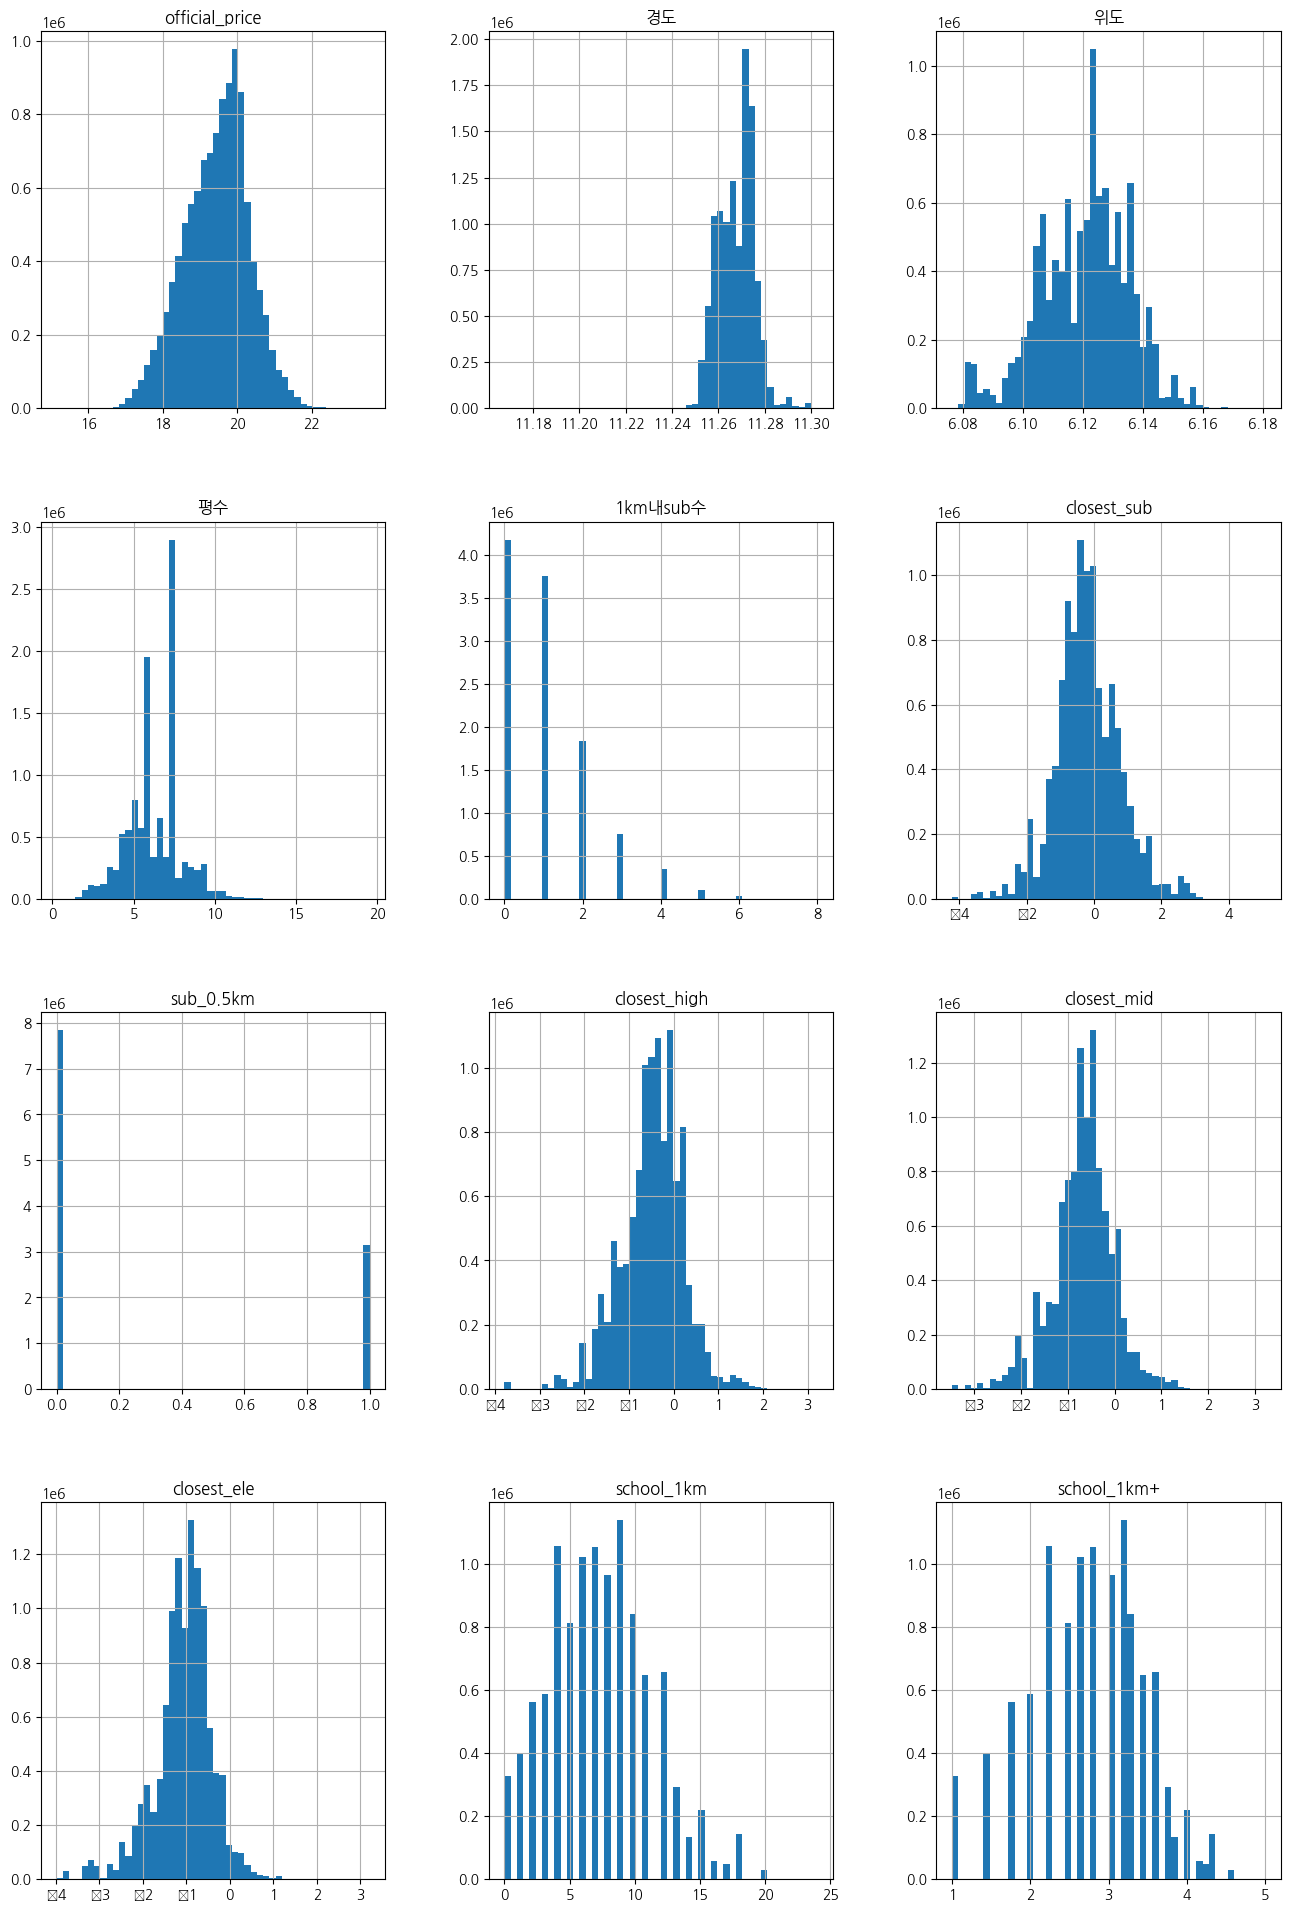

In [84]:
main_withPrice.hist(bins=50, figsize=(16, 24))
plt.rc('font', family='NanumGothic')

In [85]:
main_withPrice_skew = main_withPrice.drop(['school_1km'], axis=1)

In [87]:
main_withoutPrice_skew = main_withPrice.drop(['school_1km', 'official_price'], axis=1)

In [88]:
minmax_scaler=MinMaxScaler()
scaled_features=minmax_scaler.fit_transform(main_withPrice_skew)
scaled_features2=minmax_scaler.fit_transform(main_withoutPrice_skew)
scaled_features_df = pd.DataFrame(scaled_features, columns=main_withPrice_skew.columns)
scaled_features_df2 = pd.DataFrame(scaled_features2, columns=main_withoutPrice_skew.columns)
#scaled_features3=minmax_scaler.fit_transform(main_withPrice_skew)
#scaled_features_df3 = pd.DataFrame(scaled_features3, columns=main_withPrice_skew.columns)

In [ ]:
scaled_features_df['평수'] = np.sqrt(scaled_features_df['평수'])

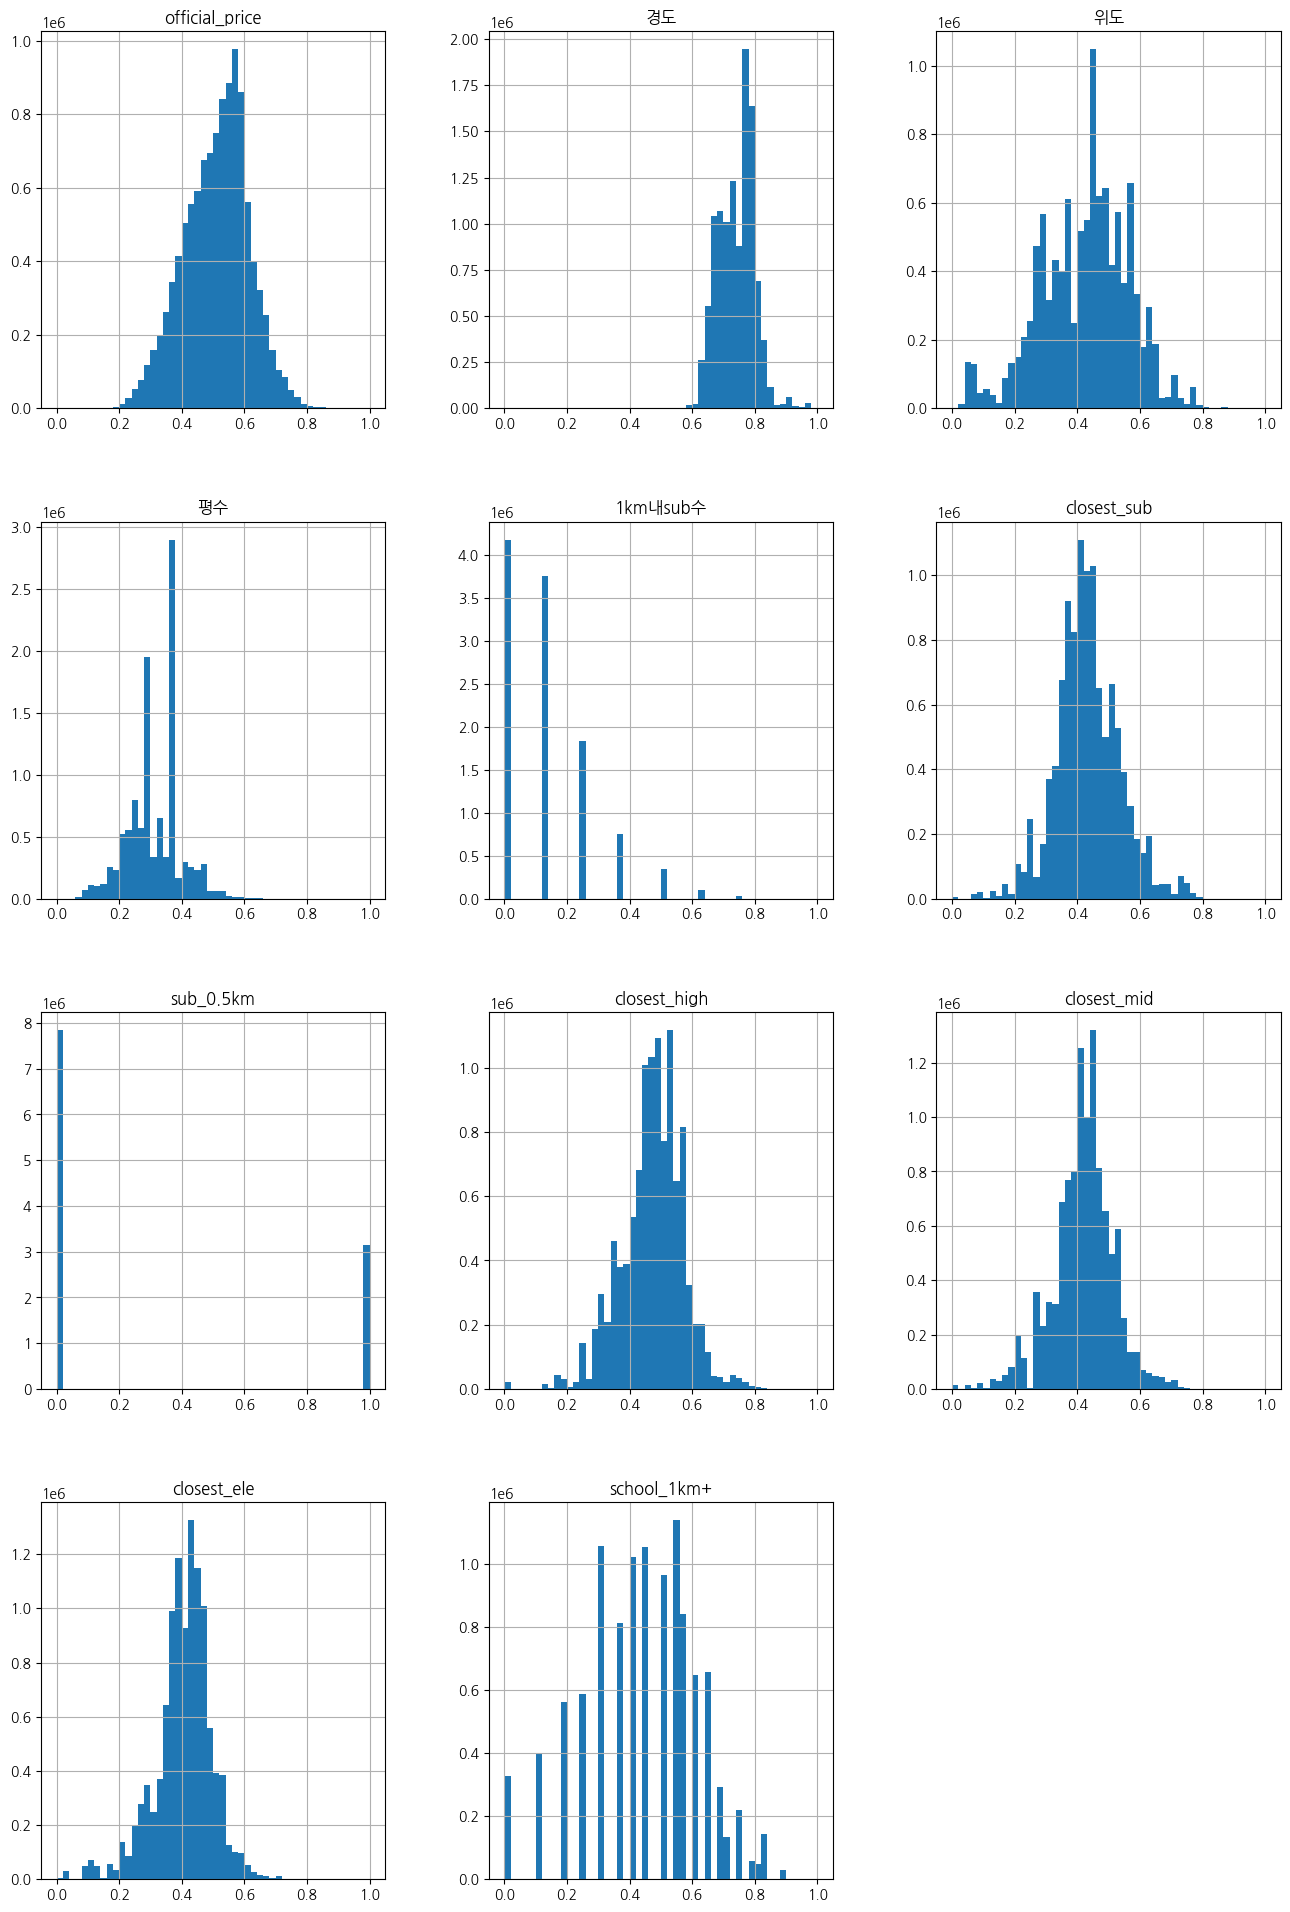

In [89]:
scaled_features_df.hist(bins=50, figsize=(16, 24))
plt.rc('font', family='NanumGothic')

<Axes: title={'center': '수도권 공시지가 상관관계'}>

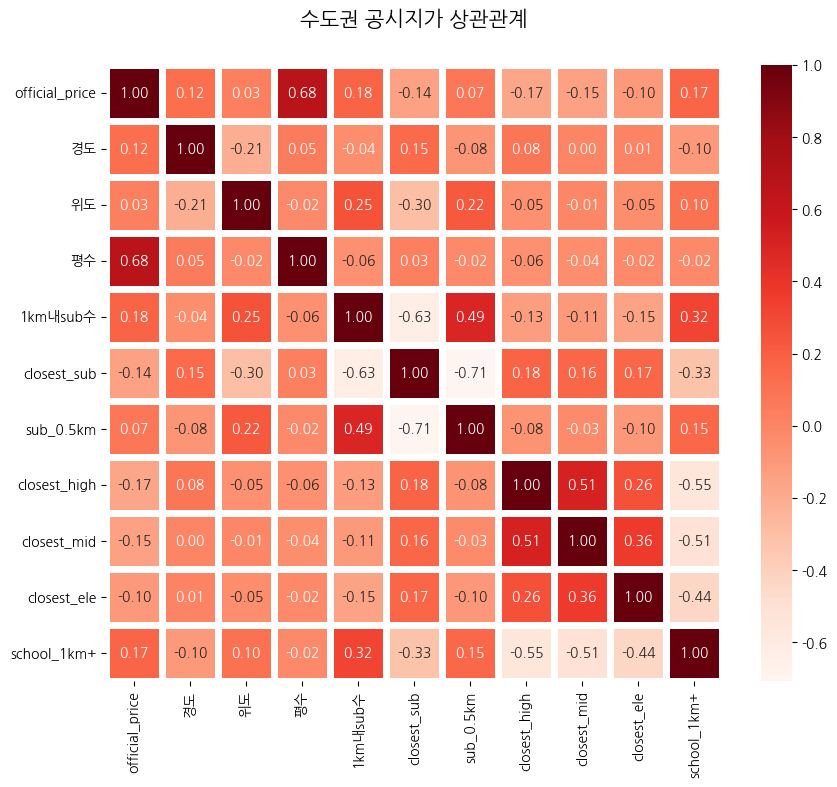

In [90]:
plt.figure(figsize=(10, 8))
plt.title("수도권 공시지가 상관관계", y = 1.05, size = 15)
plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)
sns.heatmap(scaled_features_df.corr(),annot=True,square=True,fmt='.2f',linewidths=5,cmap='Reds')

In [92]:
scaled_features_df.drop(['sub_0.5km'], axis=1, inplace=True)

In [ ]:
#plt.scatter(scaled_features_df['층수'], scaled_features_df['거래가격'], label='층수')
#plt.scatter(scaled_features_df['지하철역 수'], scaled_features_df['거래가격'], label='지하철역 수')
#plt.scatter(scaled_features_df['학교 수'], scaled_features_df['거래가격'], label='학교 수')
#plt.scatter(scaled_features_df['area_encoded'], scaled_features_df['거래가격'], label='평형')
#plt.scatter(scaled_features_df['floor_encoded'], scaled_features_df['거래가격'], label='층수')

# add legend, axis labels, and title
#plt.legend()
#plt.xlabel('')
#plt.ylabel('거래가격')
#plt.title('거래가격 상관관계')
#plt.rc('font', family='NanumGothic')
#plt.show()

In [94]:
X, y = scaled_features_df2, scaled_features_df['official_price']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_normal = scaler.fit_transform(X_train)

x_train, x_valid, y_train, y_valid = train_test_split(X_normal, y_train, test_size=0.2, random_state=1)

In [95]:
# 선형회귀모델

from sklearn.linear_model import LinearRegression

linear = LinearRegression()
linear.fit(x_train, y_train)

LinearRegression()

In [96]:
y_pred_li = linear.predict(x_train)

In [97]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

lin_R2 = r2_score(y_train, y_pred_li)
lin_mae = mean_absolute_error(y_train, y_pred_li)
print(lin_R2)
print(lin_mae)

0.5404841101377039
0.05564105751446265


In [98]:
y_pred_li = linear.predict(x_valid)
lin_r2 = r2_score(y_valid, y_pred_li)
lin_mae = mean_absolute_error(y_valid, y_pred_li)
print(lin_R2)
print(lin_mae)

0.5404841101377039
0.05564617795075175


In [99]:
# 의사결정나무

from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()
tree.fit(x_train, y_train)

y_pred_tr = tree.predict(x_train)

tree_R2 = r2_score(y_train, y_pred_tr)
tree_mae = mean_absolute_error(y_train, y_pred_tr)
print(tree_R2)
print(tree_mae)

0.9888901436626105
0.005856483810959386


In [100]:
y_pred_tr = tree.predict(x_valid)

tree_R2 = r2_score(y_valid, y_pred_tr)
tree_mae = mean_absolute_error(y_valid, y_pred_tr)
print(tree_R2)
print(tree_mae)

0.980414993106374
0.007179070837077403


In [124]:
# 랜덤포레스트

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_train)
rf_R2 = r2_score(y_train, y_pred_rf)
rf_mae = mean_absolute_error(y_train, y_pred_rf)
print(rf_R2)
print(rf_mae)

KeyboardInterrupt: 

In [ ]:
rf_R2 = r2_score(y_valid, y_pred_rf)
rf_mae = mean_absolute_error(y_valid, y_pred_rf)
print(rf_R2)
print(rf_mae)

In [118]:
# XGBoost 회귀

import xgboost

xgb_model = xgboost.XGBRegressor()
xgb_model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [119]:
y_pred_xgb = xgb_model.predict(x_train)

xgb_R2 = r2_score(y_train, y_pred_xgb)
xgb_mae = mean_absolute_error(y_train, y_pred_xgb)
print(xgb_R2)
print(xgb_mae)

0.8840327801153907
0.025678394640273064


In [102]:
# k-fold 교차검증 선형회귀모델

def display_scores(model, scores):
    print('<<', model, '모델 평가 결과 >>')
    print('평균 RMSE: ', scores.mean())
    print('표준편차: ', scores.std())

from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(linear, x_valid, y_valid, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

In [103]:
display_scores('선형회귀', lin_rmse_scores)

<< 선형회귀 모델 평가 결과 >>
평균 RMSE:  0.07008859281426433
표준편차:  6.772223890604761e-05


In [111]:
# k-fold 교차검증 의사결정나무
tree_scores = cross_val_score(tree, x_valid, y_valid, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores('의사결정나무', tree_rmse_scores)

<< 의사결정나무 모델 평가 결과 >>
평균 RMSE:  0.01991831619533493
표준편차:  0.0001241708906097218


In [120]:
# k-fold 교차검증 XGBoost
xgb_scores = cross_val_score(xgb_model, x_valid, y_valid, scoring='neg_mean_squared_error', cv=10)
xgb_rmse_scores = np.sqrt(-xgb_scores)
display_scores('XGBoost', xgb_rmse_scores)

<< XGBoost 모델 평가 결과 >>
평균 RMSE:  0.03521265943183671
표준편차:  0.00019066250238580423


In [ ]:
# k-fold 교차검증

def display_scores(model, scores):
    print('<<', model, '모델 평가 결과 >>')
    print('평균 RMSE: ', scores.mean())
    print('표준편차: ', scores.std())

from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(linear, x_valid, y_valid, scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

tree_scores = cross_val_score(tree, x_valid, y_valid, scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

xgb_scores = cross_val_score(xgb_model, x_valid, y_valid, scoring='neg_mean_squared_error', cv=10)
xgb_rmse_scores = np.sqrt(-xgb_scores)

display_scores('선형회귀', lin_rmse_scores)
print('\n')
display_scores('의사결정나무', tree_rmse_scores)
print('\n')
display_scores('XGBoost', xgb_rmse_scores)

In [104]:
# 최종모델의 성능평가 선형회귀모델

x_test_nor = scaler.transform(X_test)
final_pred = linear.predict(x_test_nor)

from sklearn.metrics import mean_squared_error
final_mse = mean_squared_error(y_test, final_pred)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_test, final_pred)

print('RMSE: ', final_rmse)
print('R2: ', final_r2)

RMSE:  0.07008072009132689
R2:  0.5407355271003154


In [112]:
# 최종모델의 성능평가 의사결정나무

x_test_nor = scaler.transform(X_test)
final_pred = tree.predict(x_test_nor)

from sklearn.metrics import mean_squared_error
final_mse = mean_squared_error(y_test, final_pred)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_test, final_pred)

print('RMSE: ', final_rmse)
print('R2: ', final_r2)

RMSE:  0.014515002686936795
R2:  0.9802984687867204


In [121]:
# 최종모델의 성능평가 XGBoost

x_test_nor = scaler.transform(X_test)
final_pred = xgb_model.predict(x_test_nor)

from sklearn.metrics import mean_squared_error
final_mse = mean_squared_error(y_test, final_pred)
final_rmse = np.sqrt(final_mse)
final_r2 = r2_score(y_test, final_pred)

print('RMSE: ', final_rmse)
print('R2: ', final_r2)

RMSE:  0.03523771482640009
R2:  0.883886901869412


In [113]:
# 예측값과 실제값의 비교 - 시각화

pred = pd.DataFrame(final_pred, columns=['prediction'])
actual = pd.DataFrame(y_test)
actual.reset_index(inplace=True, drop=True)
table = pd.concat([pred, actual], axis=1)

table

,prediction,official_price
0,0.530812,0.525624
1,0.335989,0.339941
2,0.532918,0.538913
3,0.577811,0.572449
4,0.371412,0.371412
...,...,...
2199555,0.364670,0.361718
2199556,0.479819,0.484764
2199557,0.482430,0.484764
2199558,0.496359,0.493041


<Axes: >

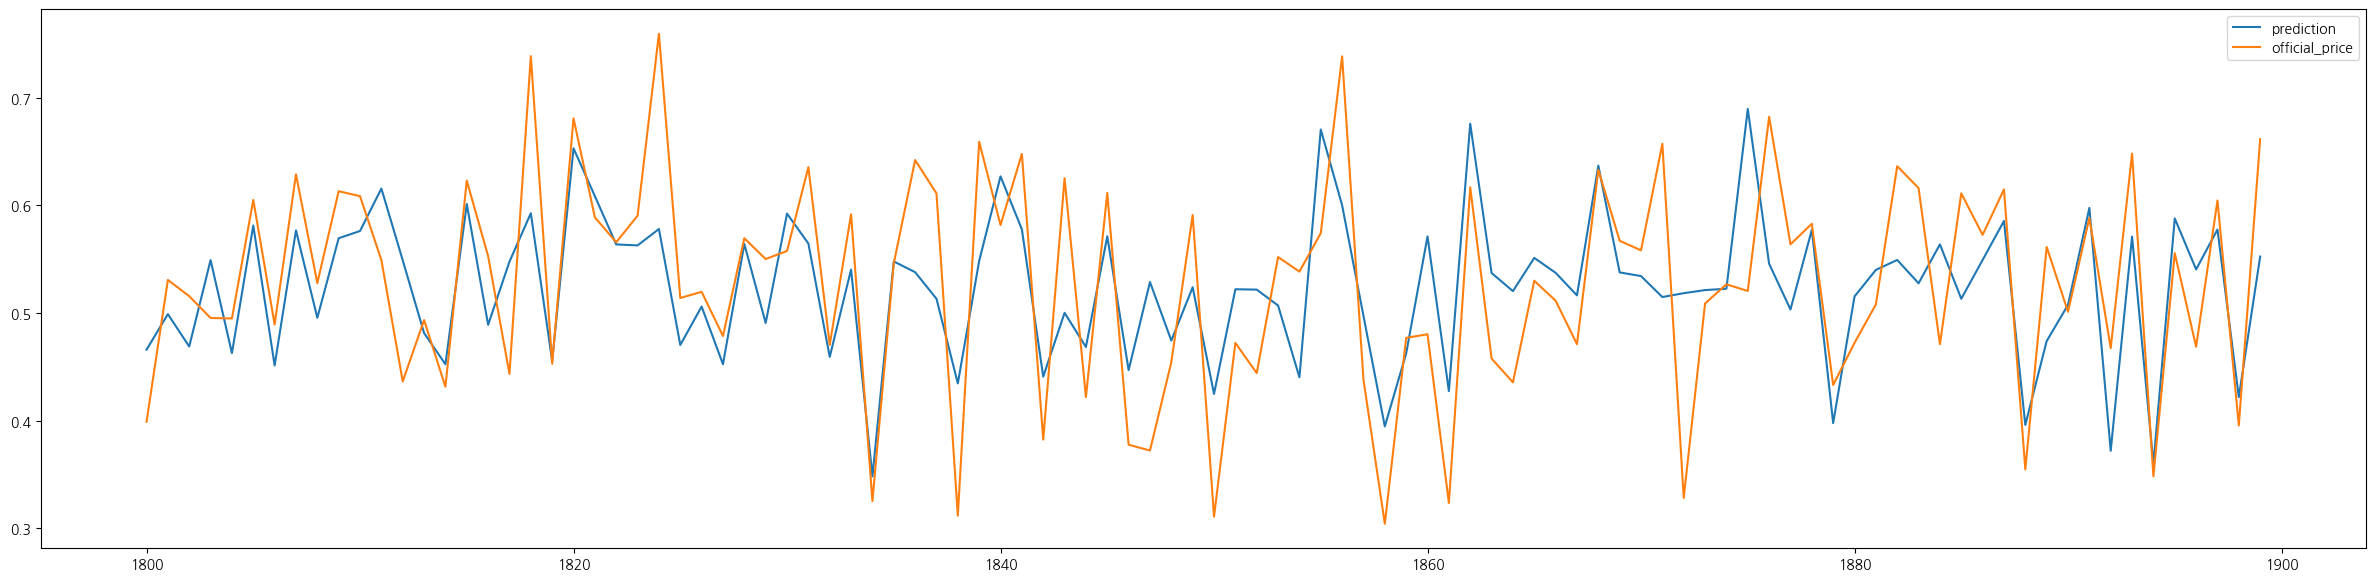

In [110]:
# 선형회귀모델 예측 정확도 시각화

plt.rc('font', family='NanumGothic')
table.iloc[1800:1900, :].plot(figsize=(30,7))

<Axes: >

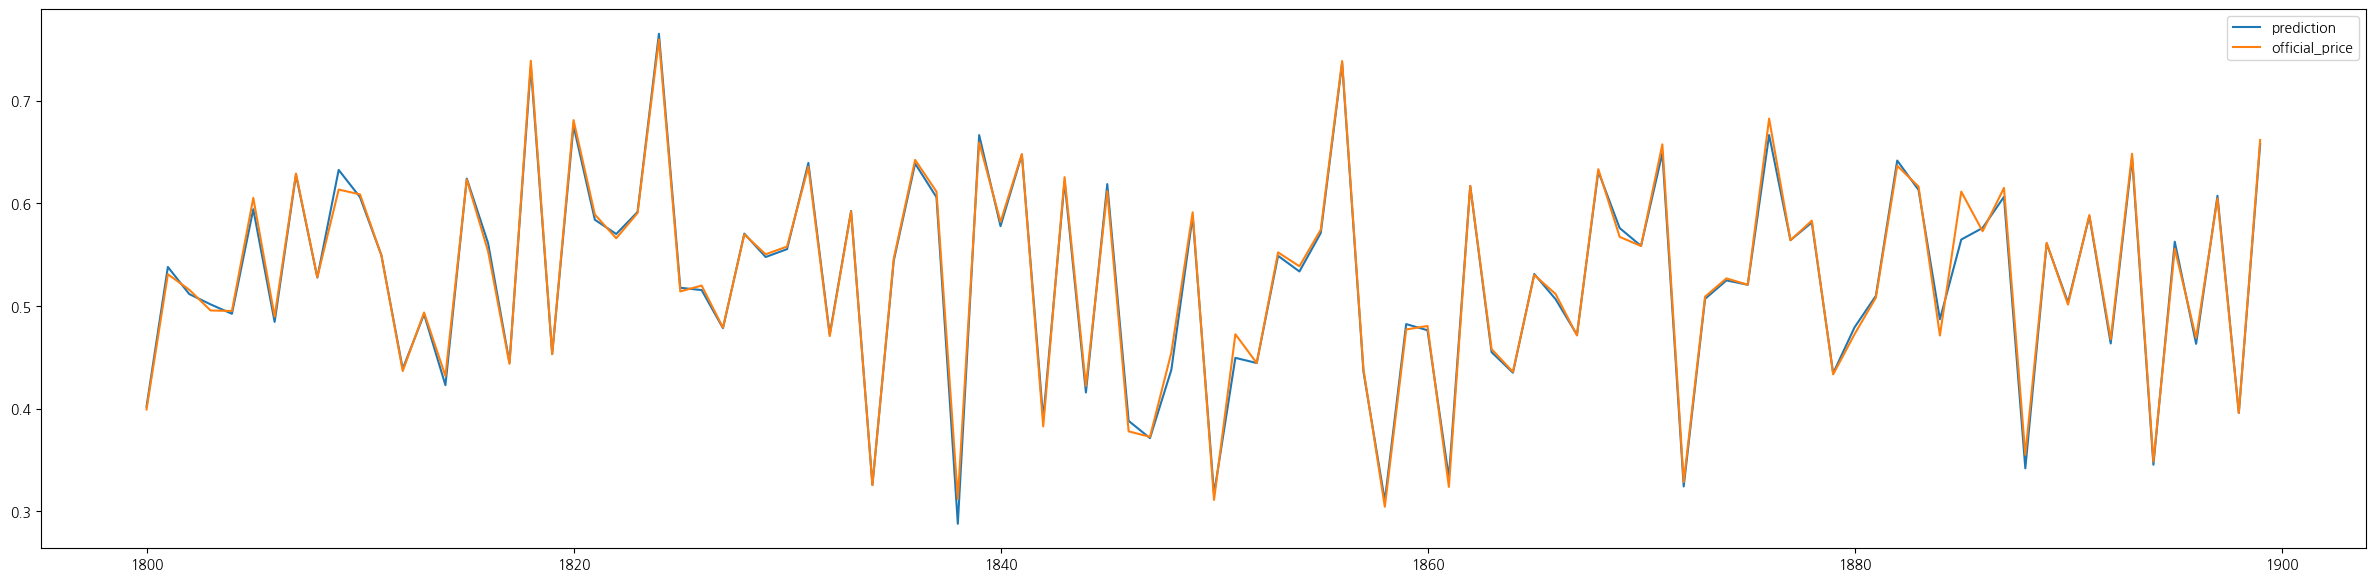

In [114]:
# 의사결정나무 예측 정확도 시각화

plt.rc('font', family='NanumGothic')
table.iloc[1800:1900, :].plot(figsize=(30,7))

<Axes: >

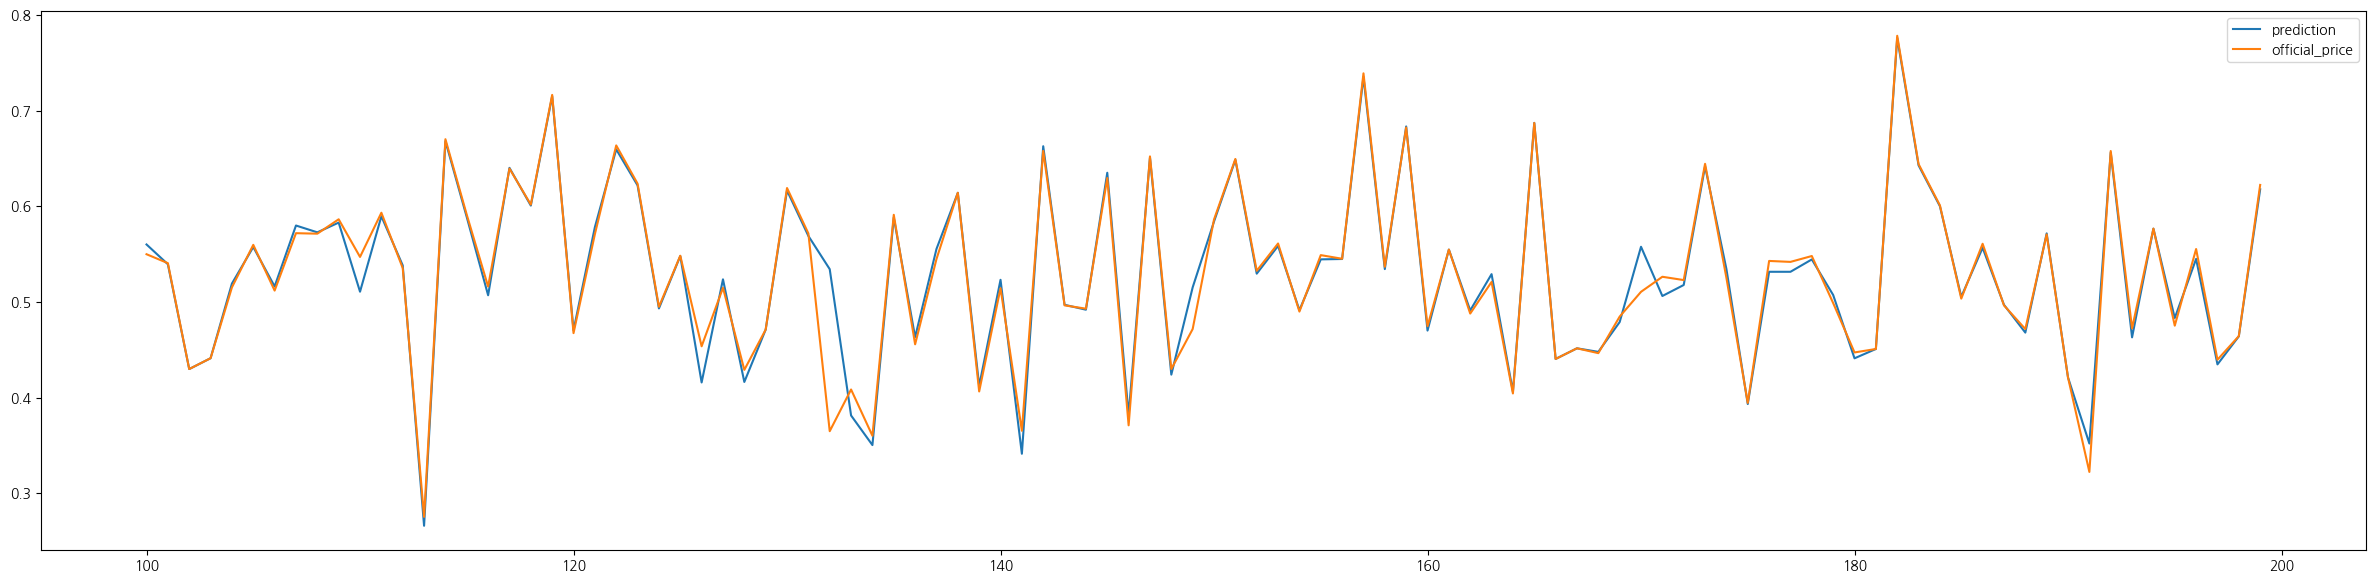

In [117]:
plt.rc('font', family='NanumGothic')
table.iloc[100:200, :].plot(figsize=(30,7))

In [122]:
# 예측값과 실제값의 비교 - 시각화 XGBoost

pred = pd.DataFrame(final_pred, columns=['prediction'])
actual = pd.DataFrame(y_test)
actual.reset_index(inplace=True, drop=True)
table = pd.concat([pred, actual], axis=1)

table

,prediction,official_price
0,0.509541,0.525624
1,0.337388,0.339941
2,0.502384,0.538913
3,0.562967,0.572449
4,0.314509,0.371412
...,...,...
2199555,0.392560,0.361718
2199556,0.524502,0.484764
2199557,0.518864,0.484764
2199558,0.436531,0.493041


<Axes: >

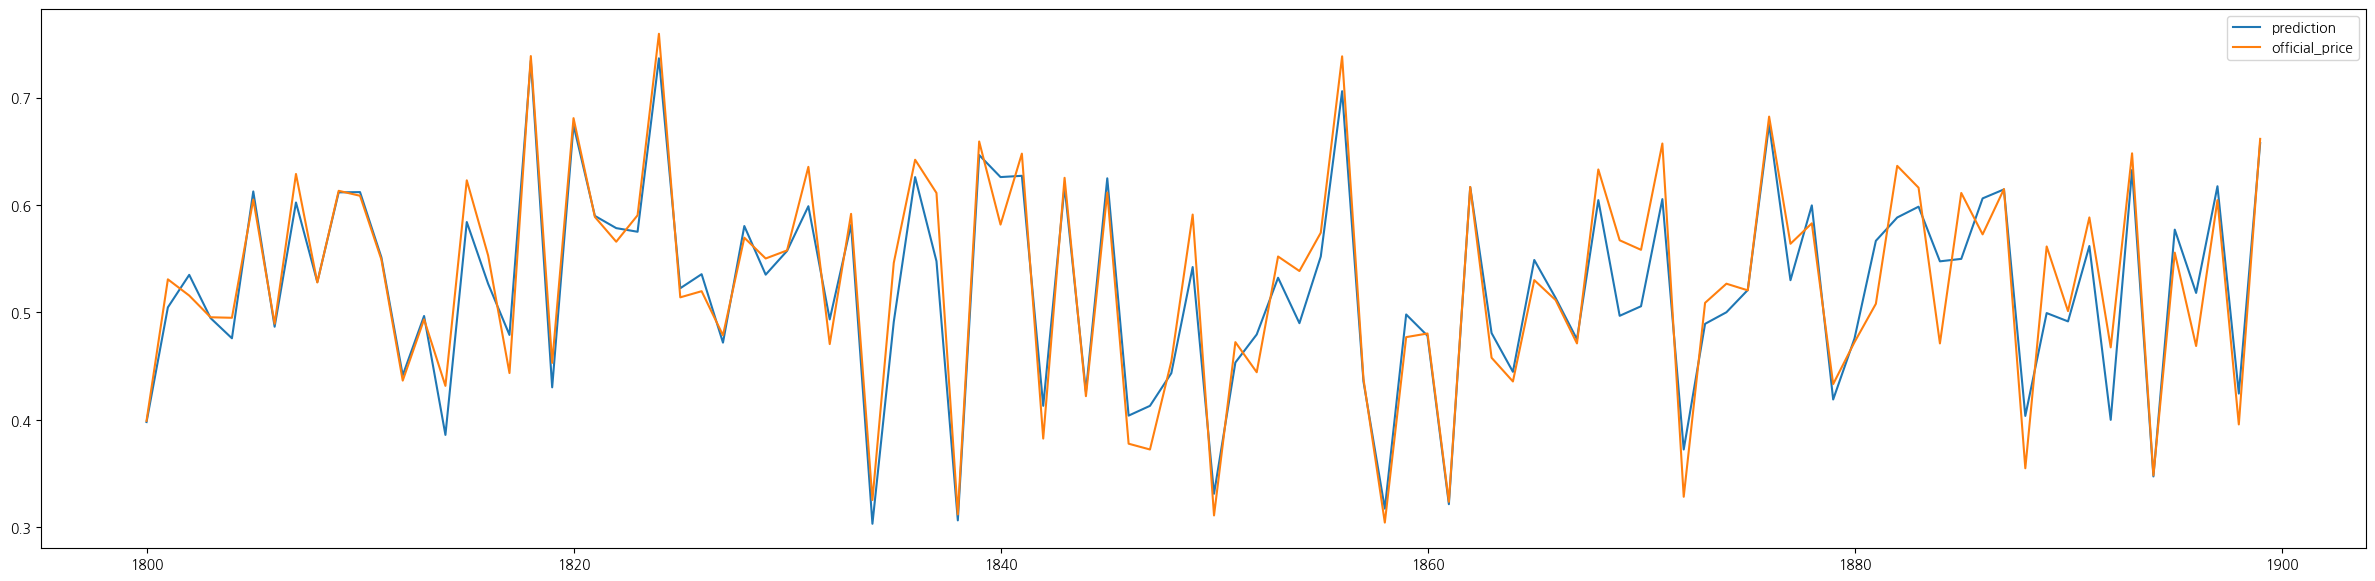

In [123]:
# XGBoost 예측 정확도 시각화

plt.rc('font', family='NanumGothic')
table.iloc[1800:1900, :].plot(figsize=(30,7))

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

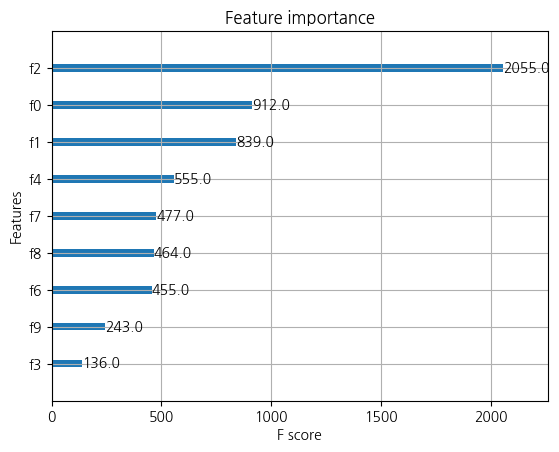

In [125]:
from xgboost import plot_importance
plot_importance(xgb_model)

In [126]:
scaled_features_df2

,경도,위도,평수,1km내sub수,closest_sub,sub_0.5km,closest_high,closest_mid,closest_ele,school_1km+
0,0.914298,0.714183,0.341903,0.0,0.564782,0.0,0.682465,0.619074,0.620942,0.000000
1,0.914298,0.714183,0.341903,0.0,0.564782,0.0,0.682465,0.619074,0.620942,0.000000
2,0.914298,0.714183,0.341903,0.0,0.564782,0.0,0.682465,0.619074,0.620942,0.000000
3,0.914298,0.714183,0.341903,0.0,0.564782,0.0,0.682465,0.619074,0.620942,0.000000
4,0.914298,0.714183,0.341903,0.0,0.564782,0.0,0.682465,0.619074,0.620942,0.000000
...,...,...,...,...,...,...,...,...,...,...
10997792,0.622328,0.430644,0.266603,0.0,0.505935,0.0,0.348174,0.634573,0.649525,0.103553
10997793,0.622328,0.430644,0.266603,0.0,0.505935,0.0,0.348174,0.634573,0.649525,0.103553
10997794,0.622328,0.430644,0.266603,0.0,0.505935,0.0,0.348174,0.634573,0.649525,0.103553
10997795,0.622328,0.430644,0.266603,0.0,0.505935,0.0,0.348174,0.634573,0.649525,0.103553


In [ ]:
# https://datascienceschool.net/03%20machine%20learning/12.01%20%EC%9D%98%EC%82%AC%EA%B2%B0%EC%A0%95%EB%82%98%EB%AC%B4.html